# Aggregate cell profiles to well-level profiles

In [35]:
# imports
import os
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import umap
from plot_utils import *
letter_dict_rev = {v: k for k, v in letter_dict.items()}
channel_dict_rev = {v: k for k, v in channel_dict.items()}

# letter_dict_rev
channel_list = list(channel_dict_rev.values())[:-3]
channel_list

%matplotlib inline
## Disable truncation globally
# pl.Config.set_tbl_rows(20)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

## define control types
TC = ["EGFP"]
NC = ["RHEB", "MAPK9", "PRKACB", "SLIRP"]
PC = ["ALK", "ALK_Arg1275Gln", "PTK2B"]
cNC = ["Renilla"]
cPC = ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
       "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]

FEAT_SETS = ["DNA", "Mito", "GFP", "AGP", "Morph"]
PLATEMAP_DIR = "../2.snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
CLASS_RES_DIR = "../../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/classification_results/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells"
IMG_QC_DIR = "../../../../3_outputs/1_snakemake_pipeline/2.smp_results_analyses/1.image_qc_outputs/{bio_rep}"

TRN_IMBAL_THRES = 5
MIN_CLASS_NUM = 2
AUROC_THRESHOLDS = [0.95, 0.99]

In [3]:
BIO_REP_BATCHES_DICT = {
    "2024_01_Batch_7-8": ("2024_01_23_Batch_7", "2024_02_06_Batch_8"),
    "2024_12_Batch_11-12": ("2024_12_09_Batch_11", "2024_12_09_Batch_12"),
    "2025_03_Batch_15-16": ("2025_03_17_Batch_15", "2025_03_17_Batch_16"),
    # "2025_01_Batch_13-14": ("2025_01_27_Batch_13", "2025_01_28_Batch_14")
}
CLASS_RES_OUTDIR = "../../../../3_outputs/1_snakemake_pipeline/2.smp_results_analyses/3.classification_results"

## 1. Get the allele info

In [7]:
clin_var_df = pl.read_csv(f"../../../../../../4_compare_AI_scores/3_outputs/varchamp_seq_confirmed_alleles_clinvar_gnomad_dbnsfp_scores.tsv", 
                          separator="\t", infer_schema_length=10000
).with_columns(
    pl.concat_str([pl.col("symbol"),pl.col("aa_change")], separator="_").alias("gene_allele")
)
imaging_summary = pl.read_csv("../../../../3_outputs/1_snakemake_pipeline/2.smp_results_analyses/3.classification_results/imaging_analyses_classification_summary.csv")

## merge the data frames
imaging_summary_clinvar = imaging_summary.join(
    clin_var_df,
    on="gene_allele",
    how="left"
).with_columns(
    pl.when(pl.col("clinvar_clnsig_clean").is_null())
    .then(pl.lit("6_No_ClinVar"))
    .otherwise(pl.col("clinvar_clnsig_clean"))
    .alias("clinvar_clnsig_clean")
)
imaging_summary_clinvar.head()

gene_allele,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,Gene,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,…,RS# (dbSNP)_dbnsfp,nsv/esv (dbVar)_dbnsfp,RCVaccession_dbnsfp,PhenotypeIDS_dbnsfp,PhenotypeList_dbnsfp,Origin_dbnsfp,OriginSimple_dbnsfp,Assembly_dbnsfp,ChromosomeAccession_dbnsfp,Chromosome_dbnsfp,Start_dbnsfp,Stop_dbnsfp,Cytogenetic_dbnsfp,ReviewStatus_dbnsfp,NumberSubmitters_dbnsfp,Guidelines_dbnsfp,TestedInGTR_dbnsfp,OtherIDs_dbnsfp,SubmitterCategories_dbnsfp,VariationID_dbnsfp,PositionVCF_dbnsfp,ReferenceAlleleVCF_dbnsfp,AlternateAlleleVCF_dbnsfp,SomaticClinicalImpact_dbnsfp,SomaticClinicalImpactLastEvaluated_dbnsfp,ReviewStatusClinicalImpact_dbnsfp,Oncogenicity_dbnsfp,OncogenicityLastEvaluated_dbnsfp,ReviewStatusOncogenicity_dbnsfp,SCVsForAggregateGermlineClassification_dbnsfp,SCVsForAggregateSomaticClinicalImpact_dbnsfp,SCVsForAggregateOncogenicityClassification_dbnsfp,clinvar_nt_change_dbnsfp,clinvar_aa_change_dbnsfp,RefSeq_mRNA_dbnsfp,StarStatus_dbnsfp,clinvar_clnsig_clean_dbnsfp
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,i64,str,str,str,str,str,…,i64,str,str,str,str,str,str,str,str,str,i64,i64,str,str,i64,str,str,str,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str
"""KCNJ2_Arg40Gln""","""2025_03_Batch_15-16""",0.972984,0.971045,0.980569,0.97502,0.961829,0.974059,0.981615,0.996136,0.990675,0.960081,0.973521,0.97633,0.988352,0.982847,0.960955,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,"""KCNJ2""","""KCNJ2""","""ENSG00000123700""",100016069,2601,"""CCSBVarC008308""","""ALE00008294""","""NC_000017.11:70175158:G:A""","""119G>A""","""Arg40Gln""",…,766143485,"""-""","""RCV000308982|RCV000347359|RCV0…","""MONDO:MONDO:0008222,MedGen:C15…","""Andersen Tawil syndrome|Atrial…","""germline;unknown""","""germline""","""GRCh38""","""NC_000017.11""","""17""",70175158,70175158,"""17q24.3""","""criteria provided, conflicting…",7,"""-""","""N""","""ClinGen:CA8738692""",2,324830,70175158,"""G""","""A""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV000405988|SCV000405989|SCV0…","""-""","""-""","""119G>A ""","""Arg40Gln""","""NM_000891.3""",1,"""3_Conflicting"""
"""FKBP6_Arg202His""","""2025_03_Batch_15-16""",0.863896,0.869514,0.904622,0.90294,0.809215,0.983654,0.982657,0.941178,0.937145,0.969693,0.923775,0.926086,0.9229,0.920042,0.889454,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"""FKBP6""","""FKBP6""","""ENSG00000077800""",10177,900211,"""CCSBVarC002929""","""ALE00002929""","""NC_000007.14:73340654:G:A""","""605G>A""","""Arg202His""",…,-1,"""-""","""RCV003974098""","""-""","""FKBP6-related disorder""","""germline""","""germline""","""GRCh38""","""NC_000007.14""","""7""",73340654,73340654,"""7q11.23""","""no assertion criteria provided""",1,"""-""","""N""","""ClinGen:CA4286754""",2,3057196,73340654,"""G""","""A""","""-""","""-""","""-""","""-""","""-""","""-""","""SCV004794340""","""-""","""-""","""605G>A ""","""Arg202His""","""NM_003602.5""",null,"""2_Benign"""
"""KCNJ2_Ile269Lys""","""2025_03_Batch_15-16""",0.753626,0.960241,0.985371,0.935121,0.809821,0.803822,0.98273,0.993124,0.962842,0.925603,0.778724,0.971485,0.989247,0.948981,0.867712,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,"""KCNJ2""","""KCNJ2""","""ENSG00000123700""",100016069,2637,"""CCSBVarC008339""","""ALE00008325""","""NC_000017.11:70175845:T:A""","""806T>A""","""Ile269Lys""",…,886042211,"""-""","""RCV000364962""","""MedGen:CN517202""","""not provided""",

In [44]:
misloc_ref_var_alleles = list(imaging_summary_clinvar.filter(pl.col("Altered_95th_perc_GFP")==1).unique("gene_allele")["gene_allele"])
misloc_ref_var_alleles += list(set([gene_allele.split('_')[0] for gene_allele in misloc_ref_var_alleles]))
# misloc_ref_var_alleles

## 2. Reading the cell profiles

In [45]:
allele_meta_df = pl.DataFrame()
allele_meta_df_dict, img_well_qc_sum_dict = {}, {}

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        allele_meta_df_batch = pl.DataFrame()
        platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
        for platemap in platemaps:
            platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
            allele_meta_df_batch = pl.concat([allele_meta_df_batch, 
                                        platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
                                        how="diagonal_relaxed").sort("plate_map_name")
            allele_meta_df_batch = allele_meta_df_batch.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
            # display(allele_meta_df.head())
        allele_meta_df = pl.concat([
            allele_meta_df,
            allele_meta_df_batch
        ], how="diagonal_relaxed")#.sort("plate_map_name") ## (~pl.col("node_type").is_in(["TC","NC","PC"]))&
    allele_meta_df_dict[bio_rep] = allele_meta_df_batch

    img_well_qc_sum = pl.read_csv(f"{IMG_QC_DIR.format(bio_rep=bio_rep)}/plate-well-level_img_qc_sum.csv")
    img_well_qc_sum = img_well_qc_sum.with_columns(
        pl.col("channel").replace("DAPI", "DNA").alias("channel")
    )
    img_well_qc_sum_morph = img_well_qc_sum.filter(pl.col("channel")!="GFP")
    img_well_qc_sum_morph = img_well_qc_sum_morph.group_by(["plate","well"]).agg(
        pl.col("is_bg").max().alias("is_bg"),
        pl.col("s2n_ratio").mean().alias("s2n_ratio")
    ).with_columns(pl.lit("Morph").alias("channel"))
    img_well_qc_sum = pl.concat([
        img_well_qc_sum.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
        img_well_qc_sum_morph.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
    ], how="vertical_relaxed")
    img_well_qc_sum_dict[bio_rep] = img_well_qc_sum

In [46]:
# Paths
feat = "GFP"
pass_qc_prof_pq_path = "../2.snakemake_pipeline/outputs/batch_profiles/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
misloc_allele_cell_qc_profile_df = pl.DataFrame()

meta_cols = [
    "Metadata_CellID",
    "Metadata_gene_allele",
    "Metadata_Well",
    "Metadata_Plate",
    "Metadata_node_type"
]

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        batch_alleles = (
            pl.scan_parquet(
                pass_qc_prof_pq_path.format(batch_id=batch_id)
            )
            .filter(pl.col("Metadata_gene_allele").is_in(misloc_ref_var_alleles))
            .with_columns(
                pl.concat_str(
                    [
                        "Metadata_Plate",
                        "Metadata_Well",
                        "Metadata_ImageNumber",
                        "Metadata_ObjectNumber",
                    ],
                    separator="_",
                ).alias("Metadata_CellID")
            )
            .select([
                "Metadata_CellID",
                "Metadata_gene_allele",
                "Metadata_Well",
                "Metadata_Plate",
                "Metadata_node_type"
            ])
        ).collect()
        feat_cols = [col for col in batch_alleles.columns if feat.lower() in col.lower()]
        batch_alleles = batch_alleles.join(
            img_well_qc_sum_dict[bio_rep].filter(pl.col("channel")==feat).select(pl.col("plate", "well", "is_bg")),
            left_on=["Metadata_Plate", "Metadata_Well"],
            right_on=["plate", "well"]
        ).filter(
            ~pl.col("is_bg")
        ).select(pl.col(meta_cols+feat_cols))
        misloc_allele_cell_qc_profile_df = pl.concat([misloc_allele_cell_qc_profile_df, batch_alleles])

In [47]:
# Paths
prof_pq_path = "../2.snakemake_pipeline/outputs/batch_profiles/{batch_id}/profiles.parquet"
misloc_allele_cell_all_profiles = []

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        batch_alleles = (
            pl.scan_parquet(
                prof_pq_path.format(batch_id=batch_id)
            )
            .filter(pl.col("Metadata_gene_allele").is_in(misloc_ref_var_alleles))
            .with_columns(
                pl.concat_str(
                    [
                        "Metadata_Plate",
                        "Metadata_Well",
                        "Metadata_ImageNumber",
                        "Metadata_ObjectNumber",
                    ],
                    separator="_",
                ).alias("Metadata_CellID")
            )
        )
        misloc_allele_cell_all_profiles.append(batch_alleles)

gfp_feats = [i for i in misloc_allele_cell_all_profiles[0].collect_schema() if feat.lower() in i.lower() and "Brightfield" not in i]
gfp_feats = ["Metadata_CellID"] + gfp_feats

misloc_allele_cell_profile_all_df = pl.concat([batch_alleles.select(gfp_feats).collect() for batch_alleles in misloc_allele_cell_all_profiles])

# This method of joining ensures that only cells past filters are included in the abundance analysis
misloc_allele_cell_profile_df = misloc_allele_cell_qc_profile_df.join(misloc_allele_cell_profile_all_df.select(gfp_feats), on="Metadata_CellID", how="left")

In [48]:
misloc_allele_cell_profile_df.shape

(1192313, 764)

## 3. Processing and profiling

### 3.1 Aggregate features to well-level

In [ ]:
def remove_corr_feats(df, corr_thres=.8):
    # 2. Identify numeric columns
    all_num_feats = [
        name
        for name, dtype in df.schema.items()
        if dtype in (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64)
    ]
    # 3. Bring that slice into pandas
    pdf = df.select(all_num_feats).to_pandas()
    # 4. Compute absolute correlation matrix
    corr = pdf.corr().abs()
    # 5. Mask out the lower triangle (we only need one side)
    upper = corr.where(
        np.triu(np.ones(corr.shape), k=1).astype(bool)
    )
    # 6. Pick columns to drop: any column with correlation > threshold to *any* other
    to_drop = [col for col in upper.columns if any(upper[col] > corr_thres)]
    # 7. Drop them in your original Polars DF
    df_drop_corr_cols = df.drop(to_drop)
    # colocal_col_cat = set(["_".join(col.split('_')[1:3]) for col in colocal_cols])
    # print(colocal_col_cat)
    # colocal_col_dict = defaultdict(list)
    # for col in colocal_cols:
    #     colocal_col_dict["_".join(col.split('_')[1:3])].append(col)
    # colocal_col_dict
    return df_drop_corr_cols


def inverse_normal_transform(data):
    """
    Apply inverse normal transformation (rank-based normalization) to data.
    """
    from scipy.stats import norm
    from scipy.stats import rankdata
    
    def transform_column_polars(col_name, df):
        """Transform a polars column"""
        return (
            pl.when(pl.col(col_name).is_not_null())
            .then(
                pl.col(col_name)
                .rank(method="average")
                .sub(0.5)
                .truediv(pl.col(col_name).drop_nulls().len())
                .map_elements(lambda x: norm.ppf(x), return_dtype=pl.Float64)
            )
            .otherwise(pl.col(col_name))
            .alias(col_name)
        )
        
    # Polars DataFrame
    numeric_cols = [col for col in data.columns if data[col].dtype in [pl.Float32, pl.Float64, pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64]]
    
    # Apply transformation to numeric columns only
    transformations = [transform_column_polars(col, data) for col in numeric_cols]
    non_numeric_cols = [col for col in data.columns if col not in numeric_cols]
    
    if transformations:
        if non_numeric_cols:
            # Keep non-numeric columns as they are
            return data.with_columns(transformations).select(data.columns)
        else:
            return data.with_columns(transformations)
    else:
        return data  # No numeric columns to transform

In [32]:
misloc_allele_well_profile_df = (
    misloc_allele_cell_profile_df.group_by(["Metadata_Plate", "Metadata_Well", "Metadata_gene_allele"])
    .agg(
        pl.col(col).median().alias(col)
        for col in misloc_allele_cell_profile_df.columns
        if not col.startswith("Metadata_")
    )
    .unique()
    .drop_nulls("Metadata_gene_allele")
)

misloc_allele_well_profile_df = misloc_allele_well_profile_df.with_columns(
    pl.col("Metadata_Plate")
      # capture a “B” followed by any non-underscore chars up to the first “A”
      .str.extract(r"(B[^_]*?A)", 1)
      .alias("Metadata_Batch")
)#.select("Metadata_Plate")

misloc_allele_well_profile_no_corr_df = remove_corr_feats(misloc_allele_well_profile_df)
misloc_allele_well_profile_no_corr_df = inverse_normal_transform(misloc_allele_well_profile_no_corr_df)

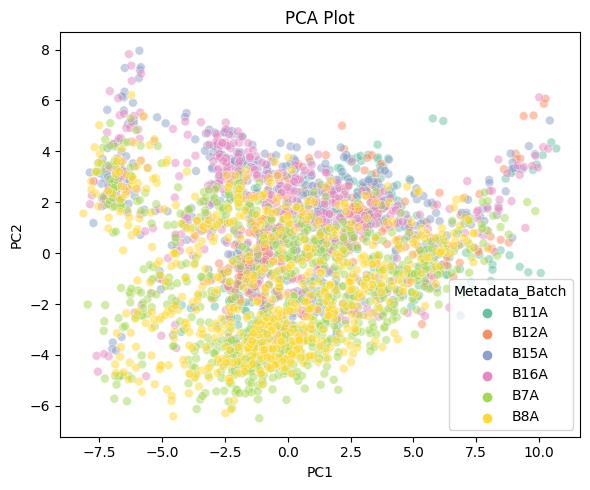

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Perform UMAP
# Perform PCA
df = misloc_allele_well_profile_no_corr_df.select(pl.col([col for col in misloc_allele_well_profile_no_corr_df.columns if not col.startswith("Metadata_")]))

# Standardize the features before PCA
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

pca = PCA(n_components=10)
pca_result = pca.fit_transform(df)

pca_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pca_df["Metadata_gene_allele"] = misloc_allele_well_profile_no_corr_df["Metadata_gene_allele"].to_numpy()
pca_df["Metadata_Batch"] = misloc_allele_well_profile_no_corr_df["Metadata_Batch"].to_numpy()
# pca_df["Metadata_variant_type"] = misloc_allele_well_profile_gfp_nocorr["Metadata_variant_type"].to_numpy()
# pca_df["Metadata_control_type"] = misloc_allele_well_profile_gfp_nocorr["Metadata_control_type"].to_numpy()

# Plot UMAP
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.scatterplot(data=pca_df.sort_values(by="Metadata_Batch"), alpha=.5,
                x="PC1", y="PC2", hue="Metadata_Batch", palette="Set2", s=40, ax=ax) ## hue=variant_type, 
# texts = []
# for i, label in enumerate(group2_labels):
#     if label in misloc_binary.filter(pl.col("mislocalized_both_batches"))["allele_0"]:
#         texts.append(ax.text(umap_result[i, 0], umap_result[i, 1], label, 
#                      fontsize=6, fontweight='bold', color='black'))
# adjust_text(texts, expand_points=(2, 2), arrowprops=dict(arrowstyle='-', color='red', lw=0.5), ax=ax) ## 
ax.set_title("PCA Plot")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(title="Metadata_Batch")
plt.tight_layout()
plt.show()

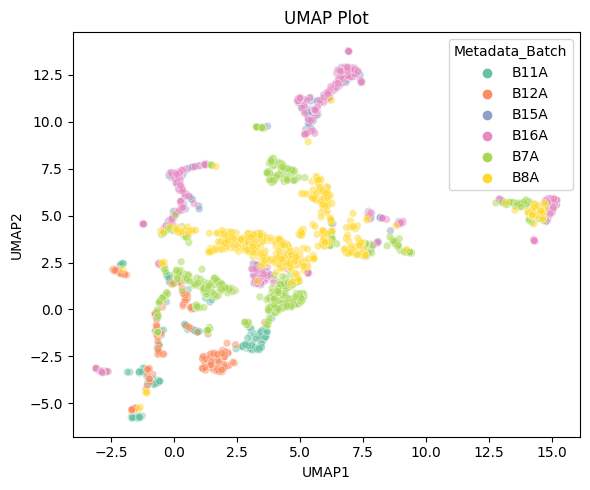

In [36]:
# from sklearn.preprocessing import StandardScaler

# Perform UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, n_jobs=1)
df = misloc_allele_well_profile_no_corr_df.select(pl.col([col for col in misloc_allele_well_profile_no_corr_df.columns if not col.startswith("Metadata_")]))

# Standardize the features before PCA
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
umap_result = umap_model.fit_transform(df.to_numpy())
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])
umap_df["Metadata_Batch"] = misloc_allele_well_profile_no_corr_df["Metadata_Batch"].to_numpy()
# umap_df["Metadata_variant_type"] = well_profiles_plate_agg["Metadata_variant_type"].to_numpy()
# umap_df["Metadata_control_type"] = well_profiles_plate_agg["Metadata_control_type"].to_numpy()

# Plot UMAP
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.scatterplot(data=umap_df.sort_values(by="Metadata_Batch"), x="UMAP1", y="UMAP2", hue="Metadata_Batch", palette="Set2", alpha=.5, s=30, ax=ax) ## hue=variant_type, 
# texts = []
# for i, label in enumerate(group2_labels):
#     if label in misloc_binary.filter(pl.col("mislocalized_both_batches"))["allele_0"]:
#         texts.append(ax.text(umap_result[i, 0], umap_result[i, 1], label, 
#                      fontsize=6, fontweight='bold', color='black'))
# adjust_text(texts, expand_points=(2, 2), arrowprops=dict(arrowstyle='-', color='red', lw=0.5), ax=ax) ## 
ax.set_title("UMAP Plot")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.legend(title="Metadata_Batch")
plt.tight_layout()
plt.show()

### 3.2 VAR Profiles - WT Profiles

In [49]:
misloc_allele_profile_df = (
    misloc_allele_cell_profile_df.group_by(["Metadata_gene_allele"])
    .agg(
        pl.col(col).median().alias(col)
        for col in misloc_allele_cell_profile_df.columns
        if not col.startswith("Metadata_")
    )
    .unique()
    .drop_nulls("Metadata_gene_allele")
)

misloc_allele_profile_df_nocorr = remove_corr_feats(misloc_allele_profile_df)
misloc_allele_profile_df_nocorr = inverse_normal_transform(misloc_allele_profile_df_nocorr)
misloc_allele_profile_df_nocorr = misloc_allele_profile_df_nocorr.to_pandas()

In [53]:
misloc_allele_profile_df_nocorr_wt = misloc_allele_profile_df_nocorr[~misloc_allele_profile_df_nocorr["Metadata_gene_allele"].str.contains("_")].copy().set_index("Metadata_gene_allele")
misloc_allele_profile_df_nocorr_var = misloc_allele_profile_df_nocorr[misloc_allele_profile_df_nocorr["Metadata_gene_allele"].str.contains("_")].copy()
misloc_allele_profile_df_nocorr_var["Gene"] = misloc_allele_profile_df_nocorr_var["Metadata_gene_allele"].apply(lambda x: x.split("_")[0])

misloc_allele_var_minus_wt = pd.DataFrame()
for gene, group in misloc_allele_profile_df_nocorr_var.groupby("Gene"):
    # print(gene)
    # display(misloc_allele_profile_df_nocorr_wt.loc[gene])
    group = group.set_index("Metadata_gene_allele").drop("Gene", axis=1).copy()
    g_col = group.columns
    # display(group)
    group = group - misloc_allele_profile_df_nocorr_wt.loc[gene]
    # display(misloc_allele_profile_df_nocorr_wt.loc[[gene]])
    misloc_allele_var_minus_wt = pd.concat([misloc_allele_var_minus_wt, group], axis=0)
    # display(misloc_allele_var_minus_wt)

display(misloc_allele_var_minus_wt)

,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,Cytoplasm_Correlation_K_AGP_GFP,...,Cells_RadialDistribution_FracAtD_GFP_8of10,Nuclei_Correlation_Correlation_AGP_GFP,Nuclei_Correlation_Costes_GFP_DNA,Nuclei_Correlation_Costes_GFP_Mito,Nuclei_Correlation_Manders_GFP_AGP,Nuclei_Correlation_Manders_GFP_DNA,Nuclei_Correlation_Manders_GFP_Mito,Nuclei_Correlation_RWC_GFP_AGP,Nuclei_Location_CenterMassIntensity_Z_GFP,Nuclei_Location_MaxIntensity_Z_GFP
Metadata_gene_allele,,,,,,,,,,,,,,,,,,,,,
AGXT_Gly116Arg,0.111944,-0.187637,0.698201,0.000000,1.036780,0.000000,1.996120,1.269785,0.000000,-0.670623,...,0.892258,0.703701,0.000000,0.0,0.0,0.0,0.0,0.973018,0.0,0.0
AGXT_Ile202Asn,0.093142,-0.169119,0.651786,0.000000,1.036780,0.000000,1.174328,1.751418,0.000000,-0.986238,...,0.837274,0.637440,0.000000,0.0,0.0,0.0,0.0,1.147353,0.0,0.0
AGXT_Asp201Asn,0.065063,-0.066438,-0.009758,0.000000,1.036780,0.000000,0.115175,1.751418,0.000000,-0.584334,...,0.209324,0.101432,0.000000,0.0,0.0,0.0,0.0,0.589769,0.0,0.0
AIPL1_Met79Thr,-0.361617,-0.968508,-0.236450,0.000000,0.000000,0.000000,0.000000,1.173390,0.000000,-0.646581,...,0.597597,1.923350,0.000000,0.0,0.0,0.0,0.0,1.389567,0.0,0.0
APOA1_Leu198Ser,-1.465145,-0.828703,-0.086525,1.269695,0.000000,0.000000,0.000000,0.344818,0.442179,0.467179,...,0.713316,-1.053805,0.000000,0.0,0.0,0.0,0.0,-1.930157,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMEM43_Arg312Trp,-3.153165,-1.546665,-1.876370,1.471827,0.000000,0.000000,0.000000,-1.372533,0.000000,1.256748,...,-1.421724,-2.066325,0.000000,0.0,0.0,0.0,0.0,-2.848366,0.0,0.0
TPM1_Asn279His,-2.726574,-0.099172,-0.999437,-3.252530,-1.765531,-2.052986,-2.309416,1.156558,-2.341784,-2.066854,...,-1.231066,-1.626527,-1.817841,0.0,0.0,0.0,0.0,-1.826255,0.0,0.0
TPM1_Glu180Gly,-2.920180,0.213295,-1.250426,-2.889631,-1.921592,-2.615557,-3.024132,2.875175,0.000000,-2.629425,...,-1.283543,-1.789482,-2.592473,0.0,0.0,0.0,0.0,-2.299297,0.0,0.0


In [208]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, optimal_leaf_ordering
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import StandardScaler
from matplotlib import colormaps
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def find_optimal_clusters_pdist(data, distance_vector, linkage_matrix, min_k, max_k):
    """Find optimal number of clusters using multiple criteria with precomputed distances."""
    from sklearn.metrics import silhouette_score, calinski_harabasz_score
    scores = {
        'silhouette': [],
        'calinski_harabasz': []
    }
    k_range = range(min_k, min(max_k + 1, len(data)))
    for k in k_range:
        labels = fcluster(linkage_matrix, k, criterion='maxclust')
        
        try:
            # Silhouette score using precomputed distances
            distance_matrix = squareform(distance_vector)
            sil_score = silhouette_score(distance_matrix, labels, metric='precomputed')
            scores['silhouette'].append(sil_score)
            
            # Calinski-Harabasz score (higher is better)
            ch_score = calinski_harabasz_score(data, labels)
            scores['calinski_harabasz'].append(ch_score)
            
        except:
            scores['silhouette'].append(-1)
            scores['calinski_harabasz'].append(0)
    
    # Find optimal k based on silhouette score
    if scores['silhouette'] and max(scores['silhouette']) > -1:
        optimal_k = k_range[np.argmax(scores['silhouette'])]
    else:
        optimal_k = min_k
    return optimal_k
    

def robust_cosine_clustering_with_annotations(df, 
                                              feature_cols,
                                              annotation_cols,
                                              continuous_annotations,
                                              n_clusters=None, 
                                              method='average', 
                                              min_clusters=2, 
                                              max_clusters=20,
                                              optimal_ordering=True):
    """
    Perform robust clustering using cosine similarities with categorical and continuous annotations.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Feature matrix with annotations (features/annotations x samples)
    feature_cols : list, optional
        List of col names to use for clustering. If None, will exclude annotation rows
    annotation_cols : list, optional
        List of categorical annotation col names (e.g., ["clinvar_clnsig_clean", "Altered_95th_perc_GFP"])
    continuous_annotations : list, optional
        List of continuous annotation row names (e.g., ["AUROC"])
    n_clusters : int, optional
        Number of clusters. If None, will be determined automatically
    method : str
        Linkage method for hierarchical clustering
    standardize : bool
        Whether to standardize features before clustering
    optimal_ordering : bool
        Whether to use optimal leaf ordering
    
    Returns:
    --------
    dict with clustering results and validation metrics
    """
    # Extract feature data for clustering
    data = df[feature_cols].astype(float)
    
    # Step 2: Compute cosine distance between columns (samples)
    # Transpose to cluster columns (samples) -> shape (n_samples, n_features)    
    # Compute cosine distance between samples
    cosine_dist = pdist(data, metric='cosine')
    
    # Step 3: Perform hierarchical clustering
    linkage_matrix = linkage(cosine_dist, method=method)
    
    # Step 4: Optimal leaf ordering to minimize distance jumps
    if optimal_ordering:
        opt_linkage = optimal_leaf_ordering(linkage_matrix, cosine_dist)
    else:
        opt_linkage = linkage_matrix
    
    # Step 5: Determine optimal number of clusters if not specified
    if n_clusters is None:
        n_clusters = find_optimal_clusters_pdist(
            data, cosine_dist, linkage_matrix, 
            min_clusters, max_clusters
        )
    
    # Step 6: Get cluster labels
    cluster_labels = fcluster(opt_linkage, n_clusters, criterion='maxclust')
    
    # Create cluster labels for samples
    sample_cluster_df = pd.DataFrame({
        'Sample': data.index,
        'Cluster': cluster_labels
    }).set_index('Sample')
    
    # Step 7: Create results dictionary
    results = {
        'data': df[feature_cols],
        'cluster_labels': cluster_labels,
        'n_clusters': n_clusters,
        'linkage_matrix': opt_linkage,
        'linkage_method': method,
        'feature_cols': feature_cols,
        'annotation_cols': annotation_cols,
        'continuous_annotations': continuous_annotations,
        'sample_clusters': sample_cluster_df,
    }
    return results


def create_column_colors_dataframe(df, clustering_results, palettes):
    """Create a DataFrame with column colors for all annotations and clusters."""
    annotation_cols = clustering_results['annotation_cols']
    continuous_annotations = clustering_results['continuous_annotations']
    sample_clusters = clustering_results['sample_clusters']
    
    col_colors_dict = {}
    palette_map = sns.color_palette("husl")
    # Add categorical annotations
    for ann_col in annotation_cols:
        if ann_col in df.columns:
            if ann_col in palettes:
                col_colors_dict[ann_col] = df[ann_col].map(palettes[ann_col])
            else:
                ann_elements = df[ann_col].unique()
                palettes[ann_col] = dict(zip(ann_elements, palette_map[:len(ann_elements)]))
                col_colors_dict[ann_col] = df[ann_col].map(palettes[ann_col])
                
    # Add cluster colors
    cluster_series = pd.Series(clustering_results['cluster_labels'], 
                               index=df.index)
    cluster_set = sorted(set(clustering_results['cluster_labels']))
    # display(cluster_series.sort_values())
    palettes['Cluster'] = dict(zip(cluster_set, sns.color_palette("husl", len(cluster_set))))
    col_colors_dict['Cluster'] = cluster_series.map(palettes['Cluster'])
    
    # Add continuous annotations (normalized to [0,1] for colormap)
    for cont_ann in continuous_annotations:
        if cont_ann in df.columns:
            values = df[cont_ann].astype(float)
            # Normalize values to [0,1]
            normalized_values = (values - values.min()) / (values.max() - values.min())
            # Apply colormap
            cmap = colormaps.get_cmap("viridis") #plt.cm.get_cmap("")
            col_colors_dict[cont_ann] = [cmap(val) for val in normalized_values]
    
    # Create DataFrame
    col_colors_df = pd.DataFrame(col_colors_dict, index=df.index)
    return col_colors_df
    

def create_comprehensive_clustermap(df, clustering_results, 
                                    cmap='vlag', 
                                    save_path=None, show_legends=True):
    """
    Create a comprehensive clustermap with all annotations and cluster information.
    """
    
    # Get the clustering data
    data = clustering_results['data']
    linkage_matrix = clustering_results['linkage_matrix']

    clinvar_palette_set2 = sns.color_palette("Set2")
    clinvar_palette_set2[0], clinvar_palette_set2[1], clinvar_palette_set2[2], clinvar_palette_set2[3], clinvar_palette_set2[4], clinvar_palette_set2[5], clinvar_palette_set2[7] = \
    clinvar_palette_set2[1], clinvar_palette_set2[4], clinvar_palette_set2[3], clinvar_palette_set2[2], clinvar_palette_set2[0], clinvar_palette_set2[7], clinvar_palette_set2[5]
    clinvar_category = ['1_Pathogenic', '2_Benign', '3_Conflicting', '4_VUS', '5_Others', '6_No_ClinVar']
    palettes = {
        "clinvar_clnsig_clean": dict(zip(clinvar_category, clinvar_palette_set2[:7]))
    }

    # Create column colors DataFrame
    col_colors_df = create_column_colors_dataframe(
        df, clustering_results, palettes
    )

    figsize = (data.shape[1] // 1.5, data.shape[1] // 4)
    # Create the clustermap
    g = sns.clustermap(
        data.T,
        col_linkage=linkage_matrix,
        col_colors=col_colors_df,
        cmap=cmap,
        figsize=figsize,
        cbar_kws={'label': 'Scaled Feature Value'},
        linewidths=0.01,
        row_cluster=True,  # Also cluster features
        xticklabels=True,  # Hide sample labels for cleaner look
        yticklabels=True
    )
    
    # Customize the plot
    g.ax_heatmap.set_xlabel('Samples (Clustered)', fontsize=8)
    g.ax_heatmap.set_ylabel('Features', fontsize=12)
    
    # Add legends if requested
    if show_legends:
        legend_y_start = 0.95
        legend_spacing = 0.22
        # Legend for categorical annotations
        for i, (ann_name, palette) in enumerate(palettes.items()):
            if ann_name in clustering_results['annotation_cols'] or ann_name == 'Cluster':
                handles = [mpatches.Patch(color=color, label=label) 
                          for label, color in palette.items()]
                
                legend = plt.legend(handles=handles, title=ann_name,
                                  bbox_to_anchor=(-.1, legend_y_start - i * legend_spacing), 
                                  bbox_transform=g.ax_heatmap.transAxes,
                                  loc='upper left')
                legend.set_title(ann_name, prop={'weight': 'bold'})
                plt.gca().add_artist(legend)
        
        # Add continuous annotation info in title or as text
        cont_info = []
        for cont_ann in clustering_results['continuous_annotations']:
            if cont_ann in df.columns:
                values = df[cont_ann].astype(float)
                cont_info.append(f"{cont_ann}: {values.min():.2f}-{values.max():.2f}")
        
        if cont_info:
            plt.figtext(0.02, 0.02, "Continuous annotations: " + ", ".join(cont_info), 
                       fontsize=10, style='italic')
    
    plt.suptitle(f'Comprehensive Variant Clustering Analysis\n'
                f'Method: {clustering_results["linkage_method"]}, '
                f'Clusters: {clustering_results["n_clusters"]}, '
                f'Features: {len(clustering_results["feature_cols"])}', 
                y=1.03, fontsize=14, weight='bold')
    
    if save_path:
        plt.savefig(save_path, dpi=400, bbox_inches='tight')
    
    return g, palettes

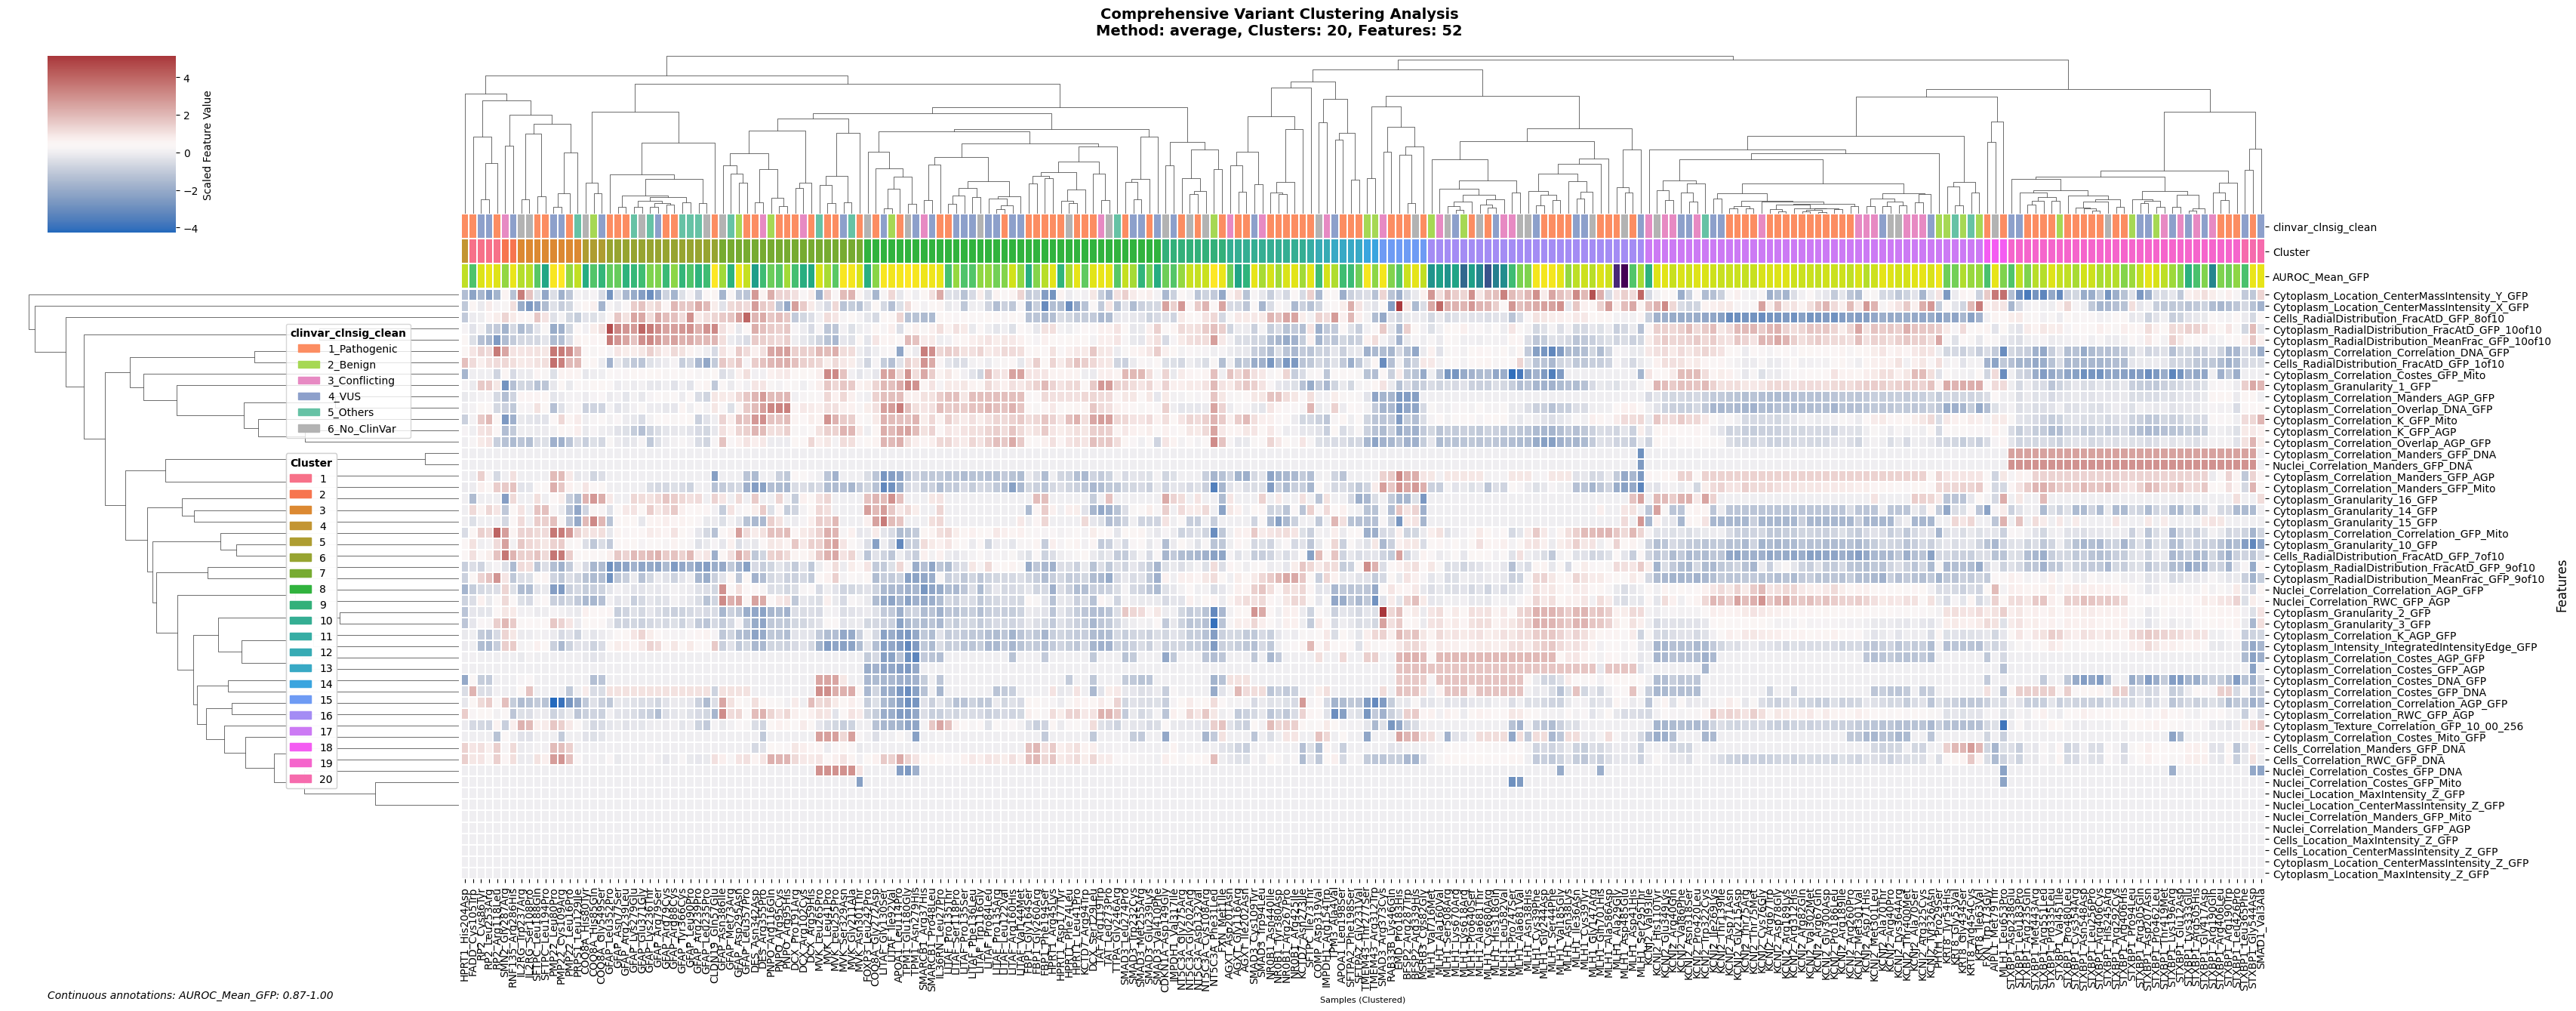

In [209]:
misloc_allele_var_minus_wt_df = misloc_allele_var_minus_wt.copy()
misloc_allele_var_minus_wt_df = pl.DataFrame(misloc_allele_var_minus_wt_df.reset_index())
misloc_allele_var_minus_wt_df = misloc_allele_var_minus_wt_df.join(
    imaging_summary_clinvar,
    left_on="Metadata_gene_allele",
    right_on="gene_allele"
)
results = robust_cosine_clustering_with_annotations(misloc_allele_var_minus_wt_df.to_pandas().set_index("Metadata_gene_allele"),
                                                    feature_cols=misloc_allele_var_minus_wt.columns,
                                                    annotation_cols=["clinvar_clnsig_clean"],
                                                    continuous_annotations=["AUROC_Mean_GFP"])
clustermap = create_comprehensive_clustermap(misloc_allele_var_minus_wt_df.to_pandas().set_index("Metadata_gene_allele"), results)

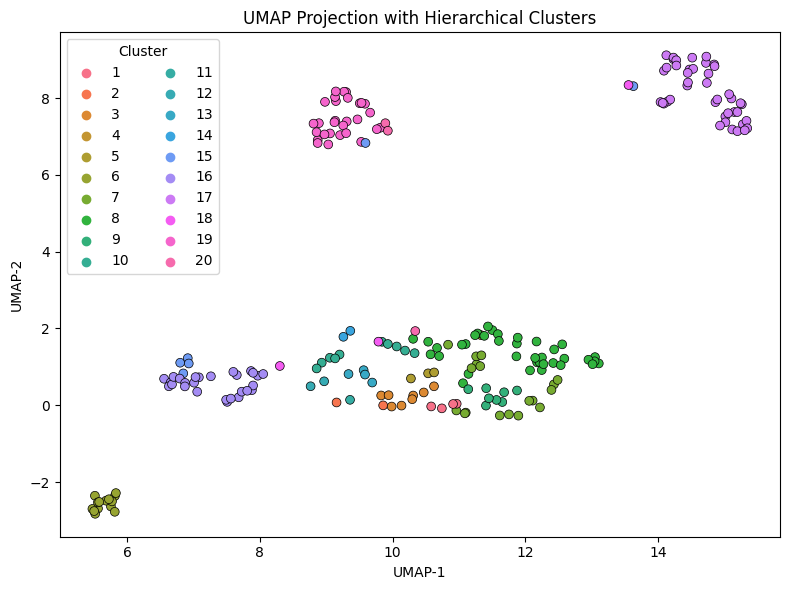

In [207]:
# ----------------------------
# 4. Compute UMAP Projection and Plot the Clusters
# ----------------------------
np.random.seed(0)
umap_reducer = umap.UMAP(random_state=0, n_jobs=1)
embedding = umap_reducer.fit_transform(results["data"])
df = pd.DataFrame()
df.loc[:,'UMAP-1'] = embedding[:, 0]
df.loc[:,'UMAP-2'] = embedding[:, 1]
df.loc[:,'Cluster'] = results["cluster_labels"]
df.index = results["data"].index

plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Cluster', 
                palette=clustermap[1]["Cluster"], data=df, s=40, edgecolor='k')
plt.title("UMAP Projection with Hierarchical Clusters")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title='Cluster', ncols=2)
plt.tight_layout()
plt.show()

In [201]:
# df.loc["HPRT1_His204Asp",:]

In [182]:
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import silhouette_score
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.cluster import AffinityPropagation
# from sklearn.mixture import BayesianGaussianMixture

# # Suppose `df_feat` is your feature DataFrame (samples × features)
# X = misloc_allele_var_minus_wt.values  # shape (n_samples, n_features)

# # Compute the full cosine similarity matrix
# sim_matrix = cosine_similarity(X)  # dense ndarray, shape (n_samples, n_samples)  [oai_citation:5‡Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html?utm_source=chatgpt.com)

# # Optional: force values into [0,1]
# # sim_matrix = np.clip(sim_matrix, 0, 1)  # ensures numerical stability  [oai_citation:6‡Data Science Portfolio](https://danielcaraway.github.io/html/sklearn_cosine_similarity.html?utm_source=chatgpt.com)

# ap_clusterer = AffinityPropagation(affinity='precomputed', random_state=42)
# ap_labels = ap_clusterer.fit_predict(sim_matrix)

# # 4. Bayesian Gaussian Mixture (Dirichlet Process) clustering
# bgm = BayesianGaussianMixture(
#     n_components=10,
#     weight_concentration_prior_type='dirichlet_process',
#     weight_concentration_prior=0.01,
#     random_state=42
# )
# bgm_labels = bgm.fit_predict(X)

# silhouette_scores = []
# cluster_range = range(2, 10)  # Trying clusters from 2 to 9
# df = misloc_allele_var_minus_wt.dropna(axis=1).copy()

# for k in cluster_range:
#     clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
#     labels = clustering.fit_predict(df)
#     score = silhouette_score(df, labels)
#     silhouette_scores.append(score)
#     print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

# # Select the number of clusters that has the highest silhouette score
# optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
# print(f"Optimal number of clusters determined: {optimal_clusters}")

# agg_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
# df.loc[:,'cluster'] = agg_model.fit_predict(df)

# df.loc[:,'bgm_cluster'] = bgm_labels
# df.loc[:,'ap_cluster'] = ap_labels

In [88]:
# import scipy.sparse as sp
# import numpy as np
# from umap.umap_ import nearest_neighbors  # UMAP precomputed-kNN helper  [oai_citation:7‡UMAP Documentation](https://umap-learn.readthedocs.io/en/latest/precomputed_k-nn.html?utm_source=chatgpt.com)
# from hidef import utils

# # Assume `df_feat` is a Polars DataFrame of shape (n_samples, n_features)
# # Convert to NumPy
# X = misloc_allele_var_minus_wt.to_numpy()  # zero-copy when possible  [oai_citation:8‡Polars User Guide](https://docs.pola.rs/docs/python/version/0.19/reference/dataframe/api/polars.DataFrame.to_numpy.html?utm_source=chatgpt.com)

# # 1. Compute kNN graph with UMAP (fuzzy simplicial set)
# knn_distances, knn_indices, _ = nearest_neighbors(
#     X,
#     n_neighbors=15,
#     metric="euclidean",
#     random_state=42
# )  # returns distances & neighbor indices  [oai_citation:9‡HiDeF](https://hidef.readthedocs.io/en/latest/tutorial/community.html) [oai_citation:10‡UMAP Documentation](https://umap-learn.readthedocs.io/en/latest/api.html?utm_source=chatgpt.com)

# # 2. Build sparse kNN matrix
# row_idx = np.repeat(np.arange(X.shape[0]), knn_indices.shape[1])
# col_idx = knn_indices.ravel()
# data = np.ones_like(row_idx, dtype=float)
# mat_knn = sp.csr_matrix((data, (row_idx, col_idx)), shape=(X.shape[0], X.shape[0]))

# # 3. Convert kNN → sNN via Jaccard similarity
# indices = utils.jaccard_matrix(mat_knn, mat_knn, threshold=0.1)
# # `indices` is a tuple of (row_inds, col_inds) for edges in the sNN graph  [oai_citation:11‡HiDeF](https://hidef.readthedocs.io/en/latest/tutorial/community.html)
# with open("snn_edges.tsv", "w") as fh:
#     for i, j in zip(indices[0], indices[1]):
#         fh.write(f"{i}\t{j}\n")